In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


In [2]:
model_id = 'microsoft/Florence-2-base'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/home/aseems/anaconda3/envs/mhcp4/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/home/aseems/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
def draw_bbox(image, data):

    fig, ax = plt.subplots()
    ax.imshow(image)
    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    ax.axis('off')
    plt.show()

In [4]:
def run_example(img, task_prompt,inputs):
    prompt = task_prompt+'tshirt'

    
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=100,
        do_sample=False,
        num_beams=1,
        early_stopping=False,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)
    answers=[]
    for i in range(len(generated_text)):
        image=Image.open("train_images/"+img[i]+".jpg")
        parsed_answer = processor.post_process_generation(
            generated_text[i],
            task=task_prompt,
            image_size=(image.width, image.height)
        )
        # draw_bbox(image, parsed_answer[ '<CAPTION_TO_PHRASE_GROUNDING>'])
        answers.append(parsed_answer)

    return answers

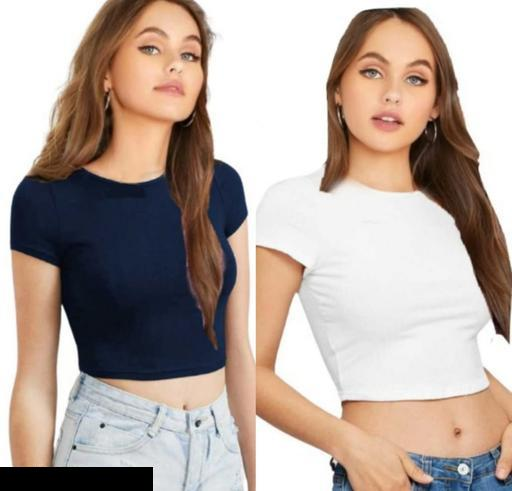

In [5]:
image=Image.open('train_images/039334.jpg')
image.show()

In [6]:
prompt='<CAPTION_TO_PHRASE_GROUNDING>'+'tshirt'
inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)

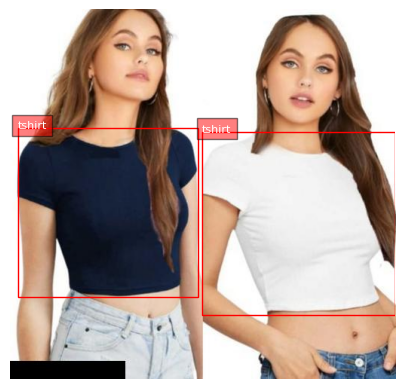

[{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[254.7200164794922, 162.27549743652344, 511.2320251464844, 404.8294982910156], [9.472000122070312, 157.36549377441406, 249.60000610351562, 381.75250244140625]], 'labels': ['tshirt', 'tshirt']}}]


In [7]:
# text_input="tshirt"
results = run_example(['039334'], task_prompt='<CAPTION_TO_PHRASE_GROUNDING>',inputs=inputs)
draw_bbox(image, results[0]['<CAPTION_TO_PHRASE_GROUNDING>'])
print(results)

In [8]:
#crop on all bounding boxes
def crop_image(results,train_dir,save_dir,img_name):
    b = results['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']
    x1=1e7
    y1=1e7
    x2=0
    y2=0
    for bbox in b:
        x1=min(x1,bbox[0])
        y1=min(y1,bbox[1])
        x2=max(x2,bbox[2])
        y2=max(y2,bbox[3])
    bbox = (x1, y1, x2, y2)
    image=Image.open(os.path.join(train_dir,img_name))
    image_cropped = image.crop(bbox)
    image_cropped.save(os.path.join(save_dir,img_name))


In [9]:

class CustomFashionManager(Dataset):
    def __init__(self,csv_file, root_dir="./",transforms =None):
        self.fashionItems = csv_file
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.fashionItems)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,f"{self.fashionItems.iloc[idx, 0]:06d}"+'.jpg')
        image = Image.open(img_name)
        prompt='<CAPTION_TO_PHRASE_GROUNDING>'+'tshirt'
        inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
        inputs['input_ids']=inputs['input_ids'][0]
        inputs['pixel_values']=inputs['pixel_values'][0]
        inputs['attention_mask']=inputs['attention_mask'][0]
        inputs['img_name']=f'{self.fashionItems.iloc[idx, 0]:06d}'
        # print(inputs.keys())
        return inputs

In [10]:
df = pd.read_csv("train.csv")
categories=df["Category"].unique()
print(categories)
category_idx=3
category=categories[category_idx]
df = df[df["Category"]==category]
# df=df.iloc[100:500,:]
df.head()
os.makedirs(f"cropped_images/",exist_ok=True)

['Men Tshirts' 'Sarees' 'Kurtis' 'Women Tshirts' 'Women Tops & Tunics']


In [11]:

dataset=CustomFashionManager(df,root_dir="train_images/")
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [ ]:
for batch in tqdm(dataloader,total=len(dataloader)):
    inputs={'input_ids':batch['input_ids'],'pixel_values':batch['pixel_values'],'attention_mask':['attention_mask']}
    results = run_example(batch['img_name'], task_prompt= '<CAPTION_TO_PHRASE_GROUNDING>',inputs=inputs)
    # print(results)
    for i in range(len(results)):
        result=results[i]
        crop_image(result,"train_images",save_dir="cropped_images/",img_name=batch['img_name'][i]+".jpg")

  0%|          | 0/1174 [00:00<?, ?it/s]